In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((64, 64))])

batch_size = 128

fmnistset = FashionMNIST('./data/', train=True, download=True, transform=transform)

trainset, valid_set = random_split(fmnistset, [50000, 10000])
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2)

testset = FashionMNIST('./data/', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('top','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','boot')

In [3]:
dataiter = iter(trainloader)
# next()함수로 다음 배치 1개 갖고오기
images, labels = next(dataiter)
print(images[0][0].shape)
print(type(labels.dtype))

torch.Size([64, 64])
<class 'torch.dtype'>


In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.conv2 = nn.Conv2d(64, 64, 5)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        
        self.conv5 = nn.Conv2d(128, 128, 3)
        self.conv6 = nn.Conv2d(128, 128, 3)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 128)
        self.fc5 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

In [7]:
train_loss_history, train_acc_history = [], []
valid_loss_history, valid_acc_history = [], []

In [8]:
epochs = 50

for epoch in range(epochs):   # 데이터셋을 수차례 반복합니다.
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    
    train_samples = 0
    valid_samples = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         scheduler.step()

        _, preds = torch.max(outputs, 1)
        train_loss += loss.item()
        train_acc += torch.sum(preds == labels.data)
        train_samples += len(inputs)
    
    else:
        # 훈련팔 필요가 없으므로 메모리 절약
        with torch.no_grad():
            for valid_input, valid_label in valid_loader:
                valid_input, valid_label = valid_input.to(device), valid_label.to(device)
                valid_outputs = net(valid_input)
                valid_loss = criterion(valid_outputs, valid_label)

                _, valid_preds = torch.max(valid_outputs, 1)
                valid_loss += valid_loss.item()
                valid_acc += torch.sum(valid_preds == valid_label.data)
                valid_samples += len(valid_input)
                
    epoch_loss = train_loss / len(trainloader)
    epoch_acc = train_acc.float() / train_samples * 100
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    valid_epoch_loss = valid_loss * 10 / len(valid_loader)
    valid_epoch_acc = valid_acc.float() / valid_samples * 100
    valid_loss_history.append(valid_epoch_loss)
    valid_acc_history.append(valid_epoch_acc)

#     if (epoch + 1) % 5 == 0:
    print(f"epoch: {epoch + 1} || tl: {epoch_loss:.3f}, vl: {valid_epoch_loss:.3f} | ta: {epoch_acc:.3f}, va: {valid_epoch_acc:.3f}")

print('Finished Training')

epoch: 1 || tl: 1.039, vl: 0.169 | ta: 60.044, va: 75.720
epoch: 2 || tl: 0.591, vl: 0.116 | ta: 76.954, va: 78.750
epoch: 3 || tl: 0.508, vl: 0.231 | ta: 80.282, va: 81.920
epoch: 4 || tl: 0.455, vl: 0.076 | ta: 82.692, va: 83.810
epoch: 5 || tl: 0.408, vl: 0.060 | ta: 84.864, va: 85.400
Finished Training


In [9]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 84 %


In [10]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

Accuracy for class top   is: 77.9 %
Accuracy for class trouser is: 95.9 %
Accuracy for class pullover is: 78.2 %
Accuracy for class dress is: 87.0 %
Accuracy for class coat  is: 71.9 %
Accuracy for class sandal is: 94.4 %
Accuracy for class shirt is: 60.7 %
Accuracy for class sneaker is: 97.5 %
Accuracy for class bag   is: 96.1 %
Accuracy for class boot  is: 91.0 %


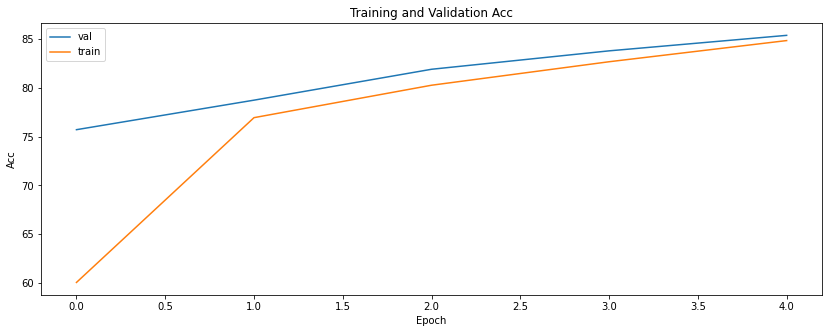

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
# plt.subplot(1, 2, 1)  
# plt.title("Training and Validation Loss")
# plt.plot(valid_loss_history,label="val")
# plt.plot(train_loss_history,label="train")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# plt.subplot(1, 2, 2) 
plt.title("Training and Validation Acc")
plt.plot(valid_acc_history,label="val")
plt.plot(train_acc_history,label="train")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [33]:
PATH = './fmnist_net.pth'
torch.save(net.state_dict(), PATH)

# net = Net()
# net.load_state_dict(torch.load(PATH))
# net.to(device)